<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Sentiment Analysis of Movie Reviews with Spacy and VADER

_Instructor: Aymeric Flaisler_

---

### Learning Objectives
- Understand the goal of basic sentiment analysis.
- Calculate sentiment scores manually using a reviews dataset and scores tagged by word.
- Practice using the spacy parser to get out part of speech tags from text.
- Fit a better model using both **sentiment** and **grammar** features.
- Use the VADER sentiment analyzer to get out more accurate sentiment scores and compare the models.

### Lesson Guide
- [Introduction to sentiment analysis](#intro)
- [Load the word sentiment dataset](#load-sen)
    - [Engineer objectivity and positive difference scores](#adj-scores)
    - [Put scores in a part of speech dictionary](#pos-dict)
- [Load the rotten tomatoes review dataset](#rt-reviews)
    - [Restrict reviews to valid lengths and ratings](#subset)
- [Import spacy](#spacy)
    - [Parse all the quotes using spacy's multithreaded parser](#multi)
- [Part of speech features](#pos-features)
- [Assign sentiment scores](#assign)
- [Print out the most positive and most negative reviews](#print-most)
- [Print out the most objective and most subjective reviews](#print-most-obj)
- [Build a model to classify fresh vs. rotten with the sentiment and grammar features](#model)
- [User the VADER library to get better sentiment scores](#vader)
    - [Build a model using the VADER sentiment features](#vader-model)

<a id='intro'></a>

## Introduction to sentiment analysis
---

Sentiment analysis is one of the most popular topics in NLP. Most commonly it is the quantification of text into **valence and subjectivity scores.**  
*Note: Valence refers to the positive or negative emotional charge some entity possesses.


First we will load in a dataset of **pre-coded sentiment scores for positivity and negativity on words**. These words are also tagged with their **part of speech** in the sentence. We can use these valence scores to evaluate the sentiment of rottentomatoes movie reviews. Many packages such as **TextBlob come pre-packaged with sentiment scores** for words after parsing text, but doing the sentiment parsing manually will show you how it can be done without any "magic".

We will also explore a more advanced sentiment analysis library in python: [VADER](https://github.com/cjhutto/vaderSentiment). We can parse the sentiment of the movie reviews using this package and compare it to our more basic method.



## Install the spacy package 
___

The spacy package is the current gold standard for parsing the grammatical structure of text (aside from neural network architectures). We are going to use it to find the part of speech tags for the review words. 

Code to install spacy:
- pip install spacy
- python -m spacy download en

<a id='load-sen'></a>

## Load the word sentiment dataset
---

Below we will load in some pre-tagged positive and negative valence scores for a dictionary of words. Each row of the dataset contains the part of speech, the word, the positive score, and the negative score for the word. A word may appear more than once if it can appear with different part of speech tags. 

These scores are designed so that we can also derive the *objectivity score* of the word from the positive and negative scores.

Objectivity is calculated: 

    1. - (positive_score + negative_score)

Thus if a score has zero positive score and negative score it is completely objective. If a score has, for example, 0.5 positive and 0.5 negative, it may not be any more positive than negative but we can tell that it is subjective (objectivity = 0.).


In [1]:
import pandas as pd
import numpy as np

In [2]:
sen = pd.read_csv('./datasets/sentiment_words_simple.csv')

In [3]:
sen.head()

,pos,word,pos_score,neg_score
0,adj,.22-caliber,0.0,0.0
1,adj,.22-calibre,0.0,0.0
2,adj,.22_caliber,0.0,0.0
3,adj,.22_calibre,0.0,0.0
4,adj,.38-caliber,0.0,0.0


In [4]:
sen.shape

(155287, 4)

**Make the part of speech tags uppercase (this will come in handy later when we use Spacy).**

Part of speech is a category of words which have similar grammatical properties. Words that are assigned to the same part of speech generally display similar behavior in terms of syntax. In other terms  they play similar roles within the grammatical structure of sentences.

In [5]:
sen.pos = sen.pos.map(lambda x: x.upper())
sen.pos.unique()

array(['ADJ', 'NOUN', 'ADV', 'VERB'], dtype=object)

<a id='adj-scores'></a>

### Engineer objectivity and positive difference scores

Since subjective vs. objective is embedded in the positive and negative scores, we should extract this and convert the positive and negative into a relative difference scores.

**Calculate two new scores:**

    objectivity = 1. - (pos_score + neg_score)
    pos_vs_neg = pos_score - neg_score
    

In [100]:
# A:
sen['objectivity'] =
sen['pos_vs_neg'] = 

In [8]:
sen.head()

,pos,word,pos_score,neg_score,objectivity,pos_vs_neg
0,ADJ,.22-caliber,0.0,0.0,1.0,0.0
1,ADJ,.22-calibre,0.0,0.0,1.0,0.0
2,ADJ,.22_caliber,0.0,0.0,1.0,0.0
3,ADJ,.22_calibre,0.0,0.0,1.0,0.0
4,ADJ,.38-caliber,0.0,0.0,1.0,0.0


<a id='pos-dict'></a>

### Put scores in a part of speech dictionary

The dictionary format of the data will be much easier to index using our parsing functions later on. Create a dictionary where the keys are the four part of speech tags:

    ADJ
    NOUN
    VERB
    ADV

For each key, store a dictionary that contains all of the words for that part of speech with their objectivity and positive vs. negative scores, ie:

```
{'ADJ': {'.22-caliber': {'objectivity': 1.0, 'pos_vs_neg': 0.0},
  '.22-calibre': {'objectivity': 1.0, 'pos_vs_neg': 0.0},
    etc.
```

In [9]:
# We help you a bit here, first understand what .itertuples() does
# then fill the '???' to answer the question:

sen_dict = {'ADJ': {}, 'NOUN': {}, 'VERB': {}, 'ADV': {}}

for row in tqdm(sen.itertuples()):
    sen_dict[row[1]][row[2]]='???'

Solution: 

<p style='color:white'>
    
sen_dict = {'ADJ': {}, 'NOUN': {}, 'VERB': {}, 'ADV': {}}

for row in tqdm(sen.itertuples()):
    sen_dict[row[1]][row[2]] = {'objectivity': row[5], 'pos_vs_neg': row[6]}
    
</p>

<a id='rt-reviews'></a>

## Load the rotten tomatoes reviews dataset

---

This dataset has:
    
    critic: critic's name
    fresh: fresh vs. rotten rating
    imdb: code for imdb
    publication: where the review was published
    quote: the review snippet
    review_date: date of review
    rtid: rottentomatoes id
    title: name of movie

In [10]:
rt = pd.read_csv('./datasets/rt_critics.csv')

In [11]:
rt.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
0,Derek Adams,fresh,114709.0,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559.0,Toy story
1,Richard Corliss,fresh,114709.0,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559.0,Toy story
2,David Ansen,fresh,114709.0,Newsweek,A winning animated feature that has something ...,2008-08-18,9559.0,Toy story
3,Leonard Klady,fresh,114709.0,Variety,The film sports a provocative and appealing st...,2008-06-09,9559.0,Toy story
4,Jonathan Rosenbaum,fresh,114709.0,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559.0,Toy story


<a id='subset'></a>

### Restrict data to reviews with valid ratings ['fresh','rotten'], keep only reviews over 10 words long and add a columns with the length of the quote:


In [94]:
# A:


### Let's clean up the reviews, making a column with the case and punctuation removed:

In [18]:
import string
rt['qt'] = rt.quote.map(lambda x: str(
    ''.join([y for y in list(x.lower()) if y in string.ascii_lowercase+' -'])))
rt.qt = rt.qt.map(lambda x: x.replace('-', ' '))

<a id='spacy'></a>

## Import spacy + reload the data

---

We can now use it to parse the tags, we can assign objectivity and valence scores by finding the match in our sentiment dataset.

In [7]:
import spacy
en_nlp = spacy.load('en')

In [8]:
# Just for safety we are going to reload the data (with the preprocessing done)
rt = pd.read_csv('datasets/rt_critics_prep_done.csv')
rt.head(3)

,critic,fresh,imdb,publication,quote,review_date,rtid,title,quote_len,qt
0,Derek Adams,1,114709.0,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559.0,Toy story,24,so ingenious in concept design and execution t...
1,David Ansen,1,114709.0,Newsweek,A winning animated feature that has something ...,2008-08-18,9559.0,Toy story,13,a winning animated feature that has something ...
2,Leonard Klady,1,114709.0,Variety,The film sports a provocative and appealing st...,2008-06-09,9559.0,Toy story,17,the film sports a provocative and appealing st...


**Parse a single quote:**

In [9]:
# A:
tmp = en_nlp(rt.qt.values[0])

# we can get out single words with indexing:
tmp[3]

concept

Each element of the sentence is now a spacy object with many attributes.

**Check spacy API https://spacy.io/api/token#attributes and Print out the part of speech tags for each word in the quote:**

In [10]:
# A:


<a id='multi'></a>
### Parse all the quotes using spacy's multithreaded parser

Parsing a lot of text can take quite awhile. Luckily spacy comes with multithreading functionality to speed up the process considerably. Below is code that will parse the quotes across multiple threads and assign them to a list.

In [102]:
parsed_quotes = []
for i, parsed in enumerate(en_nlp.pipe(rt.qt.values, batch_size=50, n_threads=4)):
    assert parsed.is_parsed
    if (i % 1000) == 0:
        print(i)
    parsed_quotes.append(parsed)

<a id='pos-features'></a>

## Create features with part of speech proportions

---

With our spacy parsed reviews, we have a lot of feature engineering potential even before we get to sentiment. Something simple we could do is calculate the proportion of words in the quote that have each part of speech tag. We can try using these as predictors in a model later.

**Find all the unique part of speech categories in the reviews.**

In [103]:
# A:


**We create a placeholder column for the proportion for each part of speech:**

In [38]:
for pos in unique_pos:
    rt[pos+'_prop'] = 0.

**Iterate through the reviews and calculate the proportions of each part of speech tag.**

Our aim is to obtain something like this (for each rows):
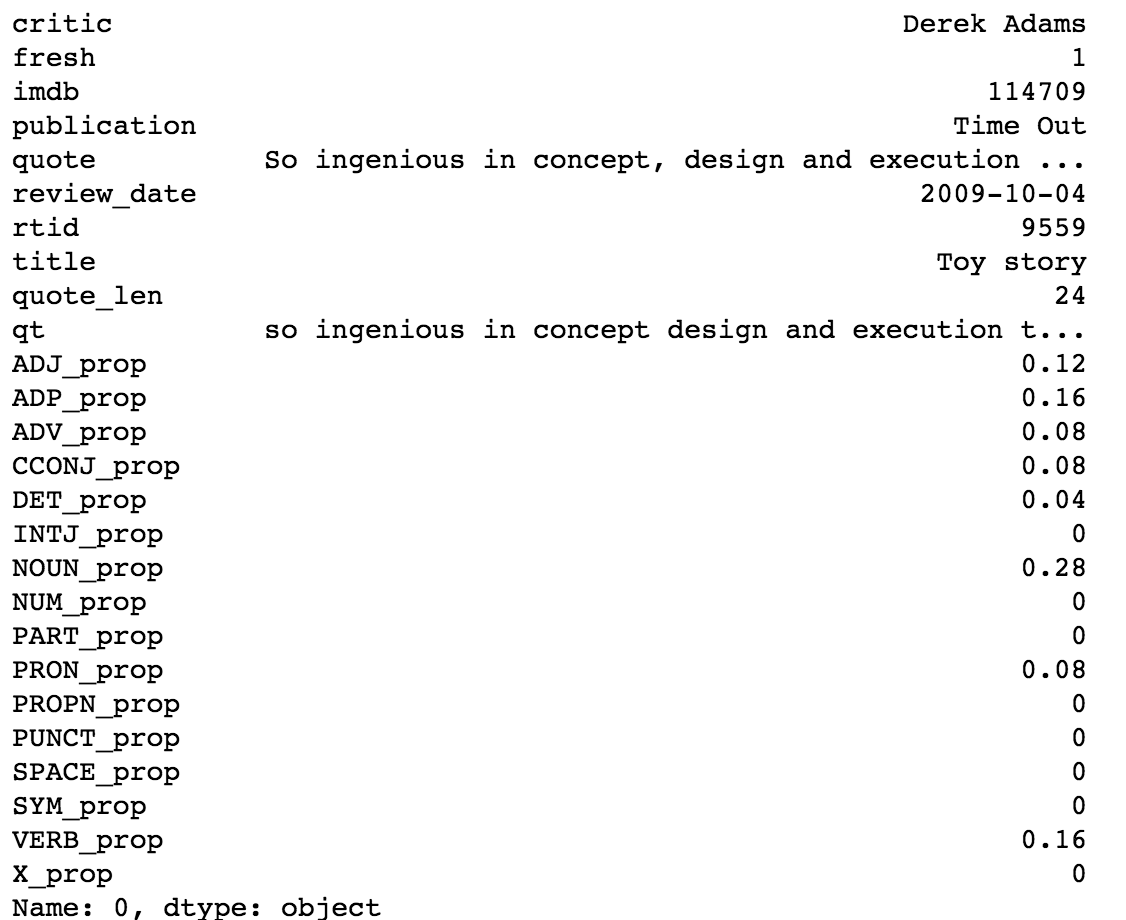

In [104]:
# A:


<a id='assign'></a>

## Assign sentiment scores
---

We will now use the parsed reviews and the sentiment dataset to assign the average objectivity and positive vs. negative scores.

If a word cannot be found in the dataset we can ignore it. If a review has no words that match something in our dataset, will can assign overall neutral scores of `objectivity = 1` and `pos_vs_neg = 0`.

There are definitely problems with this approach, but for now we can keep it "dumb" and see if things improve when we use the VADER analyzer later.

In [105]:
# A:


<a id='print-most'></a>
## Print out the most positive and most negative reviews
---

Now that we have the average valence for reviews, try printing out the top 10 most positive and top 10 most negative reviews to visually verify that our approach makes sense.

In [106]:
# A:


<a id='print-most-obj'></a>

## Print out the most objective and most subjective reviews
---

Do the same as above, but now sort by the objectivity. What kind of differences do you notice between these? Does our approach actually appear to capture meaningful subjectivity and objectivity in the reviews?

In [19]:
# A:

<a id='model'></a>

## Build a model to classify fresh vs. rotten with the sentiment and grammar features

---

Let's use the features we've created to construct a Logistic Regression to predict whether a review is fresh vs. rotten. 

Don't forget to check the baseline score, and it's a good practice to standardize your predictors.


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

<a id='vader'></a>

## Use the VADER library to get better sentiment scores
---

The [VADER](https://github.com/cjhutto/vaderSentiment) package for python is a more advanced way to calculate positivity, negativity, and objectivity in our reviews. The github page describes VADER as:

> VADER Sentiment Analysis. VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.

You will likely need to install VADER with pip or conda. Instructions can be found on the github page. Once you have it installed you can load the `SentimentIntensityAnalyzer` and parse text.

**Parse a couple of quotes with the `SentimentIntensityAnalyzer` and print out the dictionary of scores using `analyzer.polarity_scores`:

In [107]:
# pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [108]:
# A:


You can see that these scores look more legitimate. VADER polarity score dictionaries have 4 elements: `neg`, `pos`, `neu` and `compound`. The compound score is a single metric that represents the "overall" valence.

**Calculate the four scores for each review and save them as features in the dataframe.**

In [109]:
# A:



<a id='vader-model'></a>

### Fit a model using the VADER sentiment features

Does this model perform better? 

In [110]:
# A:


<a id='vader-top'></a>

### Print out the top most negative, positive, neutral, and subjective features by VADER score

In [26]:
# A:

